In [1]:
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%html
<style> 
table td, table th, table tr {text-align:left !important;}
</style>

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding, Isomap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import umap.umap_ as umap
from sklearn.metrics import accuracy_score
from itertools import permutations
import copy
import pickle
import time
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib as mpl
plt.rcParams['figure.figsize'] = (15, 10)

# Tämä komento määrittää tehtävän 2 interaktiivisen tilan totuusarvon
INTERACTIVE_MODE = False

# <center>521160P Johdatus Tekoälyyn<br><br>Harjoitus #4<br><br>Ohjaamaton oppiminen<br><br>Kevät 2020</center>

Tässä harjoituksessa klusteroidaan kaksidimensioisia datoja ja pudotetaan korkeadimensioisten datojen piirteiden lukumäärää. Harjoitus tulee palauttaa **26.4.2020 klo 23:59 mennessä. Lue huolellisesti palautukseen liittyvä ohjeistus tämän notebookin lopusta** (tämän harjoituksen palautusohjeet ovat hivenen erilaiset aiempien harjoituksien palautusohjeisiin verrattuna). Harjoituksesta on mahdollisuus saada 4 pistettä (2.0p + 2.0p).

Jos kohtaat ongelmia harjoitusta tehdessäsi tai sinulla on kysyttävää harjoitukseen liittyen ole yhteydessä Moodlesta löytyvän ohjelmointiharjoitus 4 foorumin kautta.

# Tehtävä 1. Kaksidimensioisten datojen klusterointi

Tässä tehtävässä klusteroidaan viittä erilaista kaksidimensioista dataa kolmella eri klusterointimenetelmällä K-means, DBSCAN ja kokoava hierarkkinen klusterointi ja arvioidaan, miten algoritmit suoriutuvat klusteroinnista. Taulukosta 1 ilmenee datojen tärkeimmät ominaisuudet. Sijoitetaan datojen näytteet kuvaajiin ja havainnollistetaan niiden todellisia klustereita eri väreillä.

<br>
<div style="width:image width px; font-size:80%; text-align:left;">
    <span>Taulukko 1. Kaksidimensioisten datojen tärkeimmät ominaisuudet</span>

| Datan nimi   | Datan kuvaus | Klustereiden lukumäärä | Näytteiden lukumäärä |
| --- | --- | --- | --- |
| **Ryhmät** | Kolme erimuotoista klusteria, joiden näytteiden tiheys klustereiden sisällä vaihtelee hivenen. | 3 | 400 |
| **Tihentymät** | Kaksi eri normaalijakaumaa noudattavaa klusteria. Klustereiden näytteet ovat osittain päällekkäin. | 2 | 4096 |
| **Maalitaulu** | Neljä klustereista on selvästi erillään muista klustereista. Kahdesta jäljelle jäävästä klusterista toinen on toisen sisällä. | 6 | 770 |
| **Timantit** | Kaksi vierekkäin olevaa timantinmuotoista klusteria, joiden näytteiden tiheys klustereiden sisällä on vakio. | 2 | 800 |
| **Tasot** | Klustereiden näytteiden tiheys vaihtelee reilusti niiden sisällä ja klustereiden välinen raja on lähes huomaamaton. | 2 | 1070 |
</div>
<br>

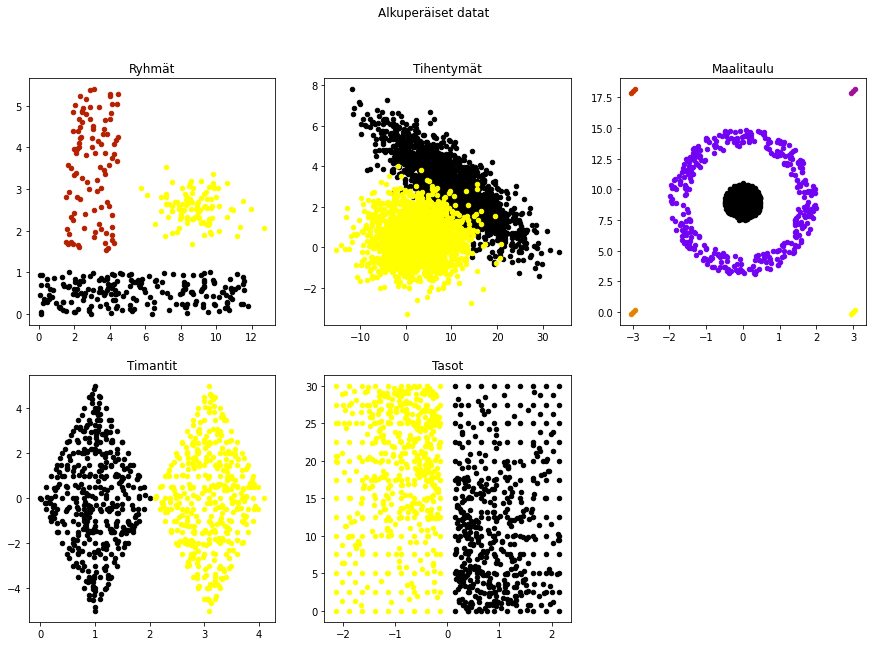

In [5]:
# Ladataan viisi erilaista kaksiulotteista dataa
data_ryhmat = np.loadtxt('data/ryhmat.txt', delimiter=',', usecols=[1,2])
luokat_ryhmat = np.loadtxt('data/ryhmat.txt', delimiter=',', usecols=[0])
data_tihentymat = np.loadtxt('data/tihentymat.txt', delimiter=',', usecols=[1,2])
luokat_tihentymat = np.loadtxt('data/tihentymat.txt', delimiter=',', usecols=[0])
data_maalitaulu = np.loadtxt('data/maalitaulu.txt', delimiter=',', usecols=[1,2])
luokat_maalitaulu = np.loadtxt('data/maalitaulu.txt', delimiter=',', usecols=[0])
data_timantit = np.loadtxt('data/timantit.txt', delimiter=',', usecols=[1,2])
luokat_timantit = np.loadtxt('data/timantit.txt', delimiter=',', usecols=[0])
data_tasot = np.loadtxt('data/tasot.txt', delimiter=',', usecols=[1,2])
luokat_tasot = np.loadtxt('data/tasot.txt', delimiter=',', usecols=[0])

# Tallennetaan alkuperäiset datat ja luokat listoihin
datat = np.array([data_ryhmat, data_tihentymat, data_maalitaulu, data_timantit, data_tasot], dtype=object)
luokat = np.array([luokat_ryhmat, luokat_tihentymat, luokat_maalitaulu, luokat_timantit, luokat_tasot], dtype=object)
otsikot = np.array(['Ryhmät','Tihentymät','Maalitaulu','Timantit','Tasot'])

# Sijoitetaan datanäytteet kaksiulotteisiin kuvaajiin
fig, axes = plt.subplots(2,3)
fig.delaxes(axes[1][2])
fig.suptitle('Alkuperäiset datat')
for i in range(datat.shape[0]):
    ax = axes[i//3,i%3]
    for j in range(luokat[i].shape[0]):
        _ , määrät = np.unique(luokat[i], return_counts=True)
        ax.scatter(datat[i][j, 0], datat[i][j, 1], c=[cm.gnuplot(luokat[i][j]/(len(määrät)-1))], s=20, marker='o')
    ax.set_title(otsikot[i])

Kuvaajista huomataan, että datojen x-akselien ja y-akselien arvoalueet eroavat toisistaan paljon. Datan normalisointi on tärkeä esikäsittelymenetelmä ennen etäisyys- ja tiheystietoa hyödyntävien klusterointialgoritmien käyttämistä. Suoritetaan datoille normalisointi niin, että molemmat muuttujat skaalautuvat välille [0,1]. Tämä lasketaan yksittäiselle muuttujalle kaavalla 1. Näytteen $x_i$ muuttujan arvosta vähennetään muuttujan pienin arvo, jonka jälkeen saatu erotus jaetaan muuttujan koko vaihteluvälillä.

<br><br>
\begin{equation}
x_{i,\: normalisoitu} = \frac{x_i - min(x)}{max(x) - min(x)} \tag{1}
\end{equation}
<br><br>

Sijoitetaan normalisoidut datanäytteet kuvaajiin. Nyt kuvaajiin ei ole havainnollistettu väreillä näytteiden todellisia klustereita. Tällaisena klusterointialgoritmit näkevät datan ennen klusteroinnin suorittamista.

Toteuta datan normalisoinnin suorittava funktio, joka skaalaa datan muuttujat välille [0,1] kaavan 1 mukaisesti. Huomaa, että kun dataa käsitellään numpy-listana, muunnoksen laskeminen onnistuu helposti matriisimuodossa. Esimerkiksi, jos datasta *$A = \text{np.array([[1,2,1],[2,3,2],[3,4,3]])}$* halutaan vähentää muuttujien keskiarvot *$B = \text{np.mean}(A, \text{axis}=0)$*, niin se onnistuu *$A-B = \text{array([[-1,-1,-1],[0,0,0],[1,1,1]])}$*.

Tarkasta piirretyistä kuvaajista, että datojen normalisoinnit onnistuivat.

<ipython-input-6-da05aad0b36c>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  datat_normalisoitu = np.array([data_ryhmat_normalisoitu, data_tihentymat_normalisoitu, data_maalitaulu_normalisoitu, data_timantit_normalisoitu, data_tasot_normalisoitu])


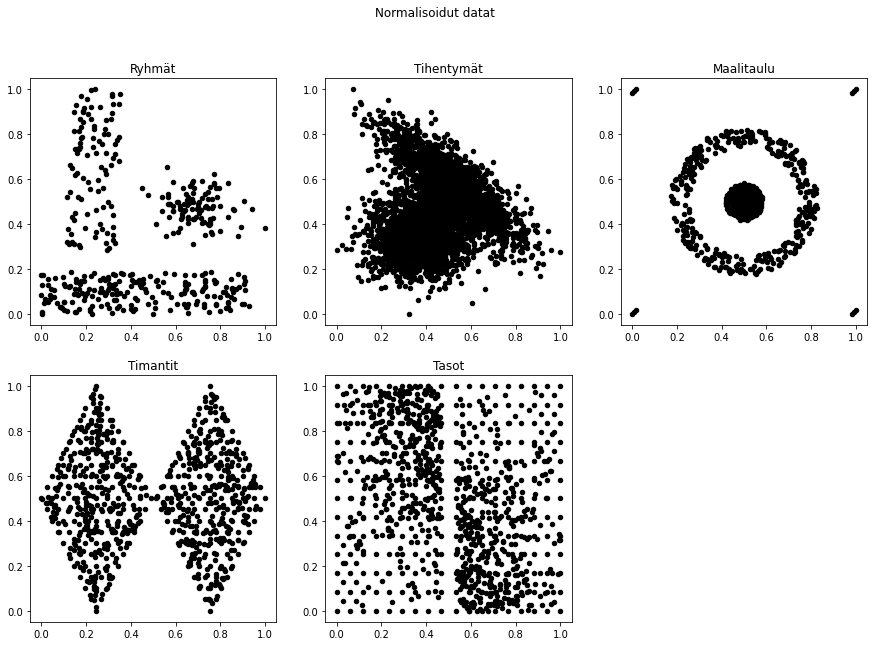

In [6]:
def normalisoi_muuttujat(data):
    """
    Tässä funktiossa normalisoidaan datan muuttujat välille [0,1].
    """
    # Selvitetään muuttujien maksimi- ja minimiarvot ja tallennetaan ne listoihin
    data_min, data_max = np.min(data, axis=0), np.max(data, axis=0)
    #-------TÄHÄN SINUN KOODI--------
    # Toteuta datan normalisointi kaavan 1 mukaisesti
    normalisoitu = (data - data_min)/(data_max - data_min)
    # Funktio palauttaa normalisoidun datan
    return normalisoitu
    #--------------------------------

# Normalisoidaan datat
data_ryhmat_normalisoitu = normalisoi_muuttujat(data_ryhmat)
data_tihentymat_normalisoitu = normalisoi_muuttujat(data_tihentymat)
data_maalitaulu_normalisoitu = normalisoi_muuttujat(data_maalitaulu)
data_timantit_normalisoitu = normalisoi_muuttujat(data_timantit)
data_tasot_normalisoitu = normalisoi_muuttujat(data_tasot)

# Tallennetaan normalisoidut datat listaan
datat_normalisoitu = np.array([data_ryhmat_normalisoitu, data_tihentymat_normalisoitu, data_maalitaulu_normalisoitu, data_timantit_normalisoitu, data_tasot_normalisoitu])

# Sijoitetaan normalisoidut datanäytteet kaksiulotteisiin kuvaajiin varmistaakseen, että datojen muuttujat skaalautuvat välille [0,1]
fig, axes = plt.subplots(2,3)
fig.delaxes(axes[1][2])
fig.suptitle('Normalisoidut datat')
for i in range(datat_normalisoitu.shape[0]):
    ax = axes[i//3,i%3]
    for j in range(luokat[i].shape[0]):
        ax.scatter(datat_normalisoitu[i][j, 0], datat_normalisoitu[i][j, 1], c='k', s=20, marker='o')
    ax.set_title(otsikot[i])

Seuraavaksi suoritetaan klusteroinnit kolmella eri klusterointialgoritmilla K-means, DBSCAN ja kokoava hierarkkinen klusterointi. Arvioidaan klusterointien onnistumista luokittelutarkkuuden avulla, joka tulostetaan kuvaajien alapuolelle.
Huomaa, että klusterointialgoritmit eivät käytä luokkatietoja hyväkseen, vaan klusteroitujen näytteiden luokkia verrataan niiden todellisiin luokkiin vasta jälkikäteen klusterointien onnistumista arvioidessa.

## K-means

Käytetään scikit-learn kirjaston funktiota [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) klusterointien suorittamiseksi. K-means-algoritmi tarvitsee etukäteen tiedon klustereiden lukumäärästä. Tämän lisäksi satunnaisesti alustettujen klusterikeskipisteiden sijasta käytetään k-means++ strategiaa, jossa klusterikeskipisteet alustetaan mahdollisimman kauas toisistaan.

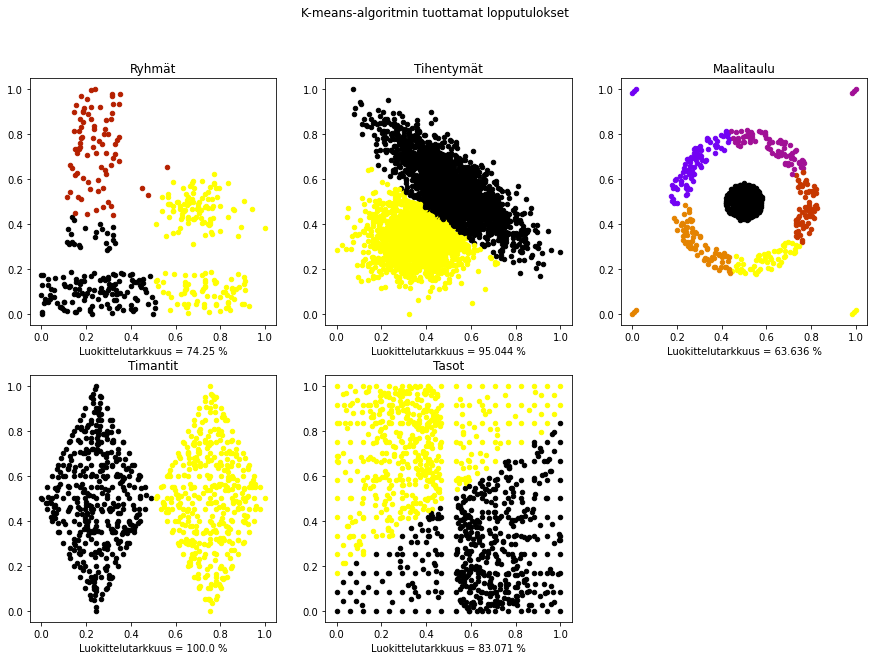

In [7]:
def suorita_K_means_klusterointi(data, klustereiden_lukumäärä):
    """
    Tässä funktiossa data klusteroidaan K-means-algoritmilla ja palautetaan lopuksi näytteiden klusteroidut luokat.
    """
    malli = KMeans(init='k-means++', n_clusters=klustereiden_lukumäärä, n_init=20, random_state=0).fit(data)
    luokat_kmeans = malli.labels_
    return luokat_kmeans

def valitse_parhaat_värit_klustereille(luokat, klusteroidut_luokat):
    """
    Tässä funktiossa valitaan klusteroiduille näytteille värit niin, että ne muistuttavat mahdollisimman paljon alkuperäisten klustereiden värejä.
    """
    kategoriat = list(set(klusteroidut_luokat))
    permutaatiot = list(permutations(kategoriat, len(kategoriat)))
    osumat = []
    luokat_muunnetut = []
    for i in range(len(permutaatiot)):
        luokat_tmp = copy.deepcopy(klusteroidut_luokat)
        for j in range(len(kategoriat)):
            luokat_tmp = [str(permutaatiot[i][j]) if x==kategoriat[j] else x for x in luokat_tmp]
        luokat_tmp = [int(i) for i in luokat_tmp]
        laskuri = 0
        for k in range(len(luokat_tmp)):
            if luokat_tmp[k] == luokat[k]:
                laskuri += 1
        osumat.append(laskuri)
        luokat_muunnetut.append(luokat_tmp)
    indeksi = osumat.index(max(osumat))
    return np.array(luokat_muunnetut[indeksi])
    
klustereiden_lukumäärät = [3,2,6,2,2]

# Sijoitetaan klusteroidut datanäytteet kaksiulotteisiin kuvaajiin
# Tämän välivaiheen ajaminen kestää hetken aikaa
fig, axes = plt.subplots(2,3)
fig.delaxes(axes[1][2])
fig.suptitle('K-means-algoritmin tuottamat lopputulokset')
for i in range(datat_normalisoitu.shape[0]):
    ax = axes[i//3,i%3]
    luokat_kmeans = suorita_K_means_klusterointi(datat_normalisoitu[i], klustereiden_lukumäärät[i])
    luokat_kmeans = valitse_parhaat_värit_klustereille(luokat[i], luokat_kmeans)
    for j in range(luokat_kmeans.shape[0]):
        ax.scatter(datat_normalisoitu[i][j, 0], datat_normalisoitu[i][j, 1], c=[cm.gnuplot(luokat_kmeans[j]/(klustereiden_lukumäärät[i]-1))], s=20, marker='o')
    ax.set_title(otsikot[i])
    ax.set_xlabel('Luokittelutarkkuus = {} %'.format(round(100*accuracy_score(luokat_kmeans, luokat[i]),3)))

## DBSCAN

Käytetään scikit-learn kirjaston funktiota [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) klusterointien suorittamiseksi. DBSCAN-algoritmi ottaa tiedon minimietäisyydestä, jolla näyte vielä kuuluu johonkin klusteriin sekä minimimäärän näytteitä, jonka muodostettavan klusterin tulee vähintään sisältää.

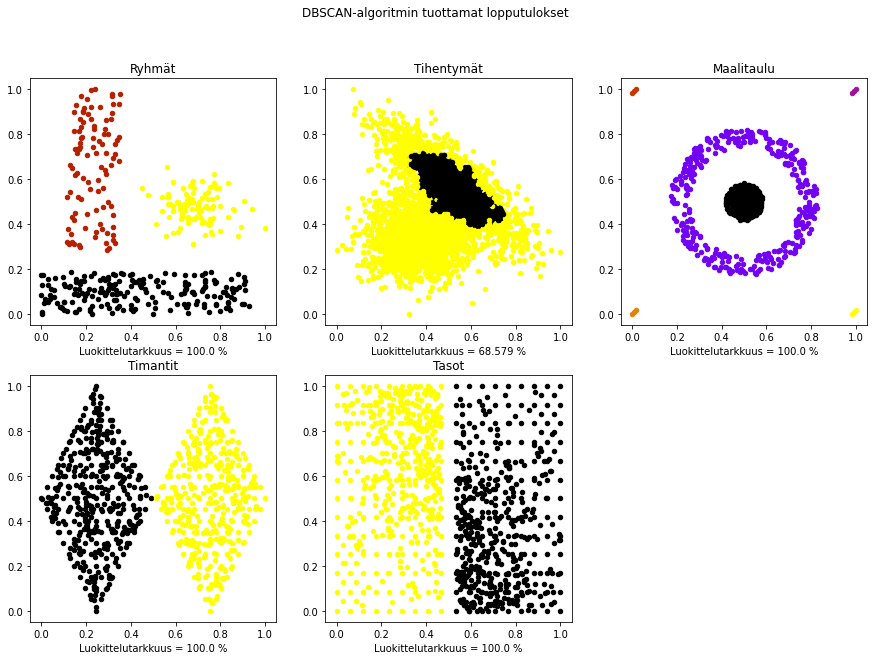

In [8]:
def suorita_DBSCAN_klusterointi(data, minimietäisyys, minimimäärä):
    """
    Tässä funktiossa data klusteroidaan DBSCAN-algoritmilla ja palautetaan lopuksi näytteiden luokat.
    """
    malli = DBSCAN(eps=minimietäisyys, min_samples=minimimäärä).fit(data)
    luokat_dbscan = malli.labels_
    luokat_dbscan = [len(set(luokat_dbscan)) if x==-1 else x for x in luokat_dbscan]
    return luokat_dbscan

minimietäisyydet = [0.1025,0.021,0.05,0.065,0.06]
minimimäärät = [2,22,2,13,2]

# Sijoitetaan klusteroidut datanäytteet kaksiulotteisiin kuvaajiin
# Tämän välivaiheen ajaminen kestää hetken aikaa
fig, axes = plt.subplots(2,3)
fig.delaxes(axes[1][2])
fig.suptitle('DBSCAN-algoritmin tuottamat lopputulokset')
for i in range(datat_normalisoitu.shape[0]):
    ax = axes[i//3,i%3]
    luokat_dbscan = suorita_DBSCAN_klusterointi(datat_normalisoitu[i], minimietäisyydet[i], minimimäärät[i])
    luokat_dbscan = valitse_parhaat_värit_klustereille(luokat[i], luokat_dbscan)
    for j in range(luokat_dbscan.shape[0]):
        ax.scatter(datat_normalisoitu[i][j, 0], datat_normalisoitu[i][j, 1], c=[cm.gnuplot(luokat_dbscan[j]/(klustereiden_lukumäärät[i]-1))], s=20, marker='o')
    ax.set_title(otsikot[i])
    ax.set_xlabel('Luokittelutarkkuus = {} %'.format(round(100*accuracy_score(luokat_dbscan, luokat[i]),3)))

## Kokoava hierarkkinen klusterointi

Käytetään scikit-learn kirjaston funktiota [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) klusterointien suorittamiseksi. Asettamalla linkitysstrategiaksi ’ward’, yhdistetään näytteet minimoiden niiden välinen varianssi. Linkitysstrategialla 'single' yhdistetään näytteet minimoiden näytejoukkojen väliset lyhimmät etäisyydet ja linkitysstrategialla 'average' yhdistetään näytteet minimoiden näytejoukkojen väliset keskiarvoistetut etäisyydet. Myös kokoava hierarkkinen klusterointi tarvitsee etukäteen tiedon klustereiden lukumäärästä.

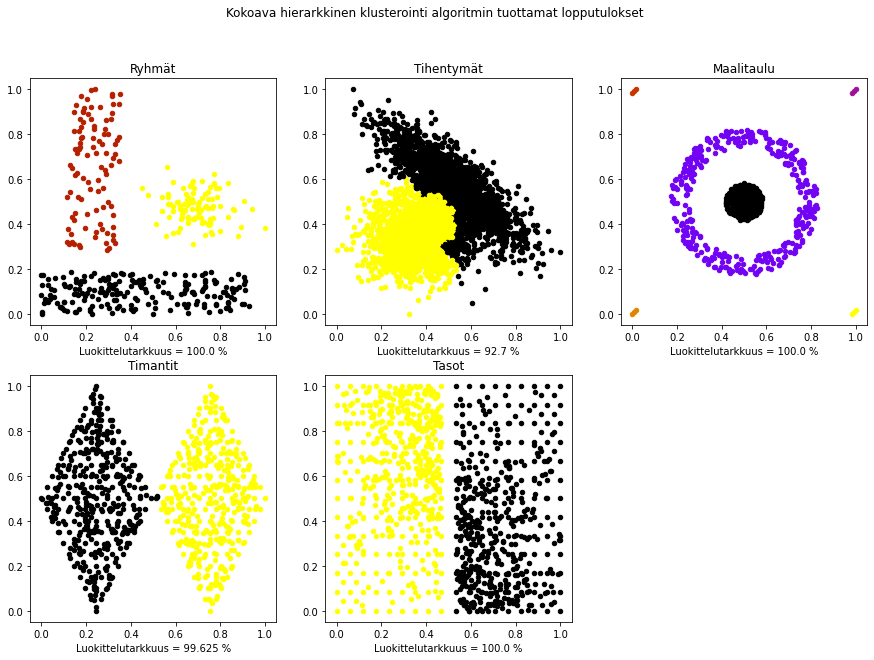

In [9]:
def suorita_kokoava_hierarkkinen_klusterointi(data, klustereiden_lukumäärä, linkitysstrategia):
    """
    Tässä funktiossa data klusteroidaan kokoavalla hierarkkisella klusteroinnilla ja palautetaan lopuksi näytteiden luokat.
    """
    malli = AgglomerativeClustering(linkage=linkitysstrategia, n_clusters=klustereiden_lukumäärä).fit(data)
    luokat_hierarkkinen = malli.labels_
    return luokat_hierarkkinen

linkitysstrategia = ['single','ward','single','average','single']

# Sijoitetaan klusteroidut datanäytteet kaksiulotteisiin kuvaajiin
# Tämän välivaiheen ajaminen kestää hetken aikaa
fig, axes = plt.subplots(2,3)
fig.delaxes(axes[1][2])
fig.suptitle('Kokoava hierarkkinen klusterointi algoritmin tuottamat lopputulokset')
for i in range(datat_normalisoitu.shape[0]):
    ax = axes[i//3,i%3]
    luokat_hierarkkinen = suorita_kokoava_hierarkkinen_klusterointi(datat_normalisoitu[i], klustereiden_lukumäärät[i], linkitysstrategia[i])
    luokat_hierarkkinen = valitse_parhaat_värit_klustereille(luokat[i], luokat_hierarkkinen)
    for j in range(luokat_hierarkkinen.shape[0]):
        ax.scatter(datat_normalisoitu[i][j, 0], datat_normalisoitu[i][j, 1], c=[cm.gnuplot(luokat_hierarkkinen[j]/(klustereiden_lukumäärät[i]-1))], s=20, marker='o')
    ax.set_title(otsikot[i])
    ax.set_xlabel('Luokittelutarkkuus = {} %'.format(round(100*accuracy_score(luokat_hierarkkinen,luokat[i]),3)))

**Miksi K-means-algoritmi ei onnistu klusteroimaan oikein dataa Ryhmät ja DBSCAN-algoritmi dataa Tihentymät?**

`Näytteiden tiheysjakauma on sillä tavalla heterogeeninen että k-means melko satunnaisilla klustereiden keskustoilla ei kykene hahmottamaan missä ryhmien rajat menevät oikeasti. DBSCAN on näytteiden tiheyteen perustuva menetelmä, jolloin päällekäin menevät klusterit on vaikea erottaa toisistaan.`

# Tehtävä 2. Dimensionaalisuuden vähentäminen

Toisessa tehtävässä luodaan kaksiulotteisia visualisointeja kolmelle eri datalle algoritmeilla [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [MDS](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html), [LLE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html), [Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html), [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) ja [UMAP](https://umap-learn.readthedocs.io/en/latest/). Tämän lisäksi pudotetaan korkeadimensioisen datan piirteiden lukumäärää ja arvioidaan sen vaikutusta opetettavan luokittelijan luokittelutarkkuuteen ja opetukseen kuluvaan aikaan.

Tehtävässä käytetään seuraavia datoja:

### Viinidata

Viinidata (engl. wines data) koostuu kolmen italialaisen viinilajikkeen eri ominaisuuksista. Data sisältää yhteensä 178 näytettä. Piirteinä on käytetty 13 viinin ominaisuutta, kuten alkoholipitoisuutta, omenahapon määrää, tuhkan määrää, magnesiumin määrää, viinin värin intensiteettiä ja värisävyä.

### Muoti MNIST-data

Muoti MNIST-data (engl. Fashion MNIST) sisältää MNIST-datan tapaan 70 000 näytettä kymmenestä eri luokasta. Näytteet ovat 28x28 pikselin kokoisia harmaasävykuvia vaatekappaleista, kuten t-paidoista, housuista, laukuista, sandaaleista, puseroista ja takeista. Kuvat on otettu mustaa taustaa vasten. Tätä tehtävää varten alkuperäisestä muoti MNIST-datasta on valittu 700 näytteen joukko algoritmien laskenta-ajan pienentämiseksi. Kuvassa 1 on esimerkkikuvia muoti MNIST-datan kaikista luokista.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='kuvat\muotimnist.png' width='950' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Kuva 1. Esimerkkikuvia muoti MNIST-datan kaikista luokista.</span>
</div>
<br>

### Oksada

Oksadata sisältää sahatavaran vikojen yleisimpiä oksatyyppejä. Oksa on kovaa puuainesta, jonka syysuunta on kohtisuorassa puun rungon syysuuntaan. Alkuperäinen oksadata sisältää erikokoisia RGB-kuvia mutta dimensionaalisuuden vähentämisten suorittamiseksi kuvat on skaalattu 40x40 pikselin kokoon. Oksien tyypit on jaettu luokkiin oksan laadun ja sahaussuunnan perusteella. Kuvassa 2 on esimerkkikuvia oksadatan kaikista luokista.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='kuvat\oksa.png' width='600' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Kuva 2. Esimerkkikuvia oksadatan kaikista luokista.</span>
</div>
<br>

Aivan aluksi ladataan datat.

In [10]:
# Ladataan datat
with open("data/viinidata.pkl", "rb") as f1:
    data_f1 = pickle.load(f1)
data_viini, luokat_viini = np.array(data_f1[0]), np.array(data_f1[1])
luokkien_nimet_viini = ['viini 1', 'viini 2', 'viini 3']

with open("data/muoti_mnist_data.pkl", "rb") as f2:
    data_f2 = pickle.load(f2)
data_muoti, luokat_muoti = np.array(data_f2[0]), np.array(data_f2[1])
luokkien_nimet_muoti = ['t-paita','housut','villapaita','mekko','takki','sandaali','paita','urheilukenkä','laukku','bootsi']

with open("data/oksadata.pkl", "rb") as f3:
    data_f3 = pickle.load(f3)
data_oksa, luokat_oksa = np.array(data_f3[0]), np.array(data_f3[1])
luokkien_nimet_oksa = ['tuoreoksa','kuiva oksa','särmäoksa','lehtioksa','sarvioksa','kuoren ympäröimä oksa','laho oksa']

## Datan visualisoiminen

Suoritetaan datoille muunnokset eri dimensionaalisuuden vähentämismenetelmillä. Muunnoksen onnistumista arvioidaan opettamalla muunnetussa ulottuvuudessa k-lähimmän naapurin luokittelija ja laskemalla opetusdatan luokittelutarkkuus. Huomaa, että dimensionaalisuuden vähentämismenetelmät eivät käytä luokkatietoja hyväkseen, vaan muunnettujen näytteiden ennustettuja luokkia verrataan niiden todellisiin luokkiin vasta jälkikäteen luokittelutarkkuutta laskiessa.

Opeta k-lähimmän naapurin luokittelija muunnetussa ulottuvuudessa, ennusta muunnetulle datalle luokat ja laske luokittelutarkkuus.

In [11]:
def muunna_data(data, parametrit=[]):
    """
    Tämä funktio muuntaa datan kahteen dimensioon eri dimensionaalisuuden vähennysmenetelmillä.
    """
    data_pca = PCA(n_components=2, random_state=0).fit_transform(data)
    data_mds = MDS(n_jobs=-1, random_state=0).fit_transform(data)
    data_lle = LocallyLinearEmbedding(eigen_solver='arpack', method='modified',n_neighbors=parametrit[0], n_jobs=-1, random_state=0).fit_transform(data)
    data_isomap = Isomap(n_neighbors=parametrit[1]).fit_transform(data)
    data_tsne = TSNE(n_components=2, perplexity=parametrit[2], metric='sqeuclidean', random_state=0, square_distances=True).fit_transform(data)
    data_umap = umap.UMAP(n_neighbors=parametrit[3], min_dist=parametrit[4], metric='correlation', random_state=0).fit_transform(data)
    datat_muunnettu = np.array([data_pca, data_mds, data_lle, data_isomap, data_tsne, data_umap])
    return datat_muunnettu

def laske_luokittelutarkkuus_muunnetussa_ulottuvuudessa(data_muunnettu, luokat, k):
    """
    Tämä funktio laskee opetusdatan luokittelutarkkuuden k-lähimmän naapurin luokittelijalle muunnetulle datalle.
    """
    # Määritetään luokittelija
    luokittelija_knn = KNeighborsClassifier(n_neighbors=k)
    #-------TÄHÄN SINUN KOODI--------
    # Opeta k-lähimmän naapurin luokittelija muunnetulla datalla (Vihje: .fit(opetusdata, opetusdatan luokat))
    luokittelija_knn.fit(data_muunnettu, luokat)
    # Ennusta luokittelijalla luokat muunnetulle datalle (Vihje: .predict(opetusdata))
    luokat_ennuste = luokittelija_knn.predict(data_muunnettu)
    # Laske opetusdatan luokittelutarkkuus luokittelijalle (Vihje: accuracy_score(opetusdatan luokat, ennustetut luokat))
    luokittelutarkkuus = accuracy_score(luokat, luokat_ennuste)
    # Funktio palauttaa luokittelutarkkuuden
    return luokittelutarkkuus
    #--------------------------------

Suoritetaan viinidatan visualisoiminen eri dimensionaalisuuden vähentämismenetelmillä.

(*Jos python-kirjasto umap-learn antaa virheilmoituksen ja käytät 32-bittistä järjestelmää, virheen voi korjata menemällä umap-kansioon (esim. C:\Users\Tuomas\AppData\Local\Programs\Python\Python37\Lib\site-packages\umap) ja korvaamalla kansion python-tiedostoista löytyvät kohdat 'parallel=True' kohdalla 'parallel=False'. Rinnakkaislaskennan poistaminen UMAP-algoritmista hiekentää hivenen sen suorituskykyä, joten suorita tämä toimenpide ainoastaan, jos ongelmia ilmenee umap-learn kirjaston kanssa.*)

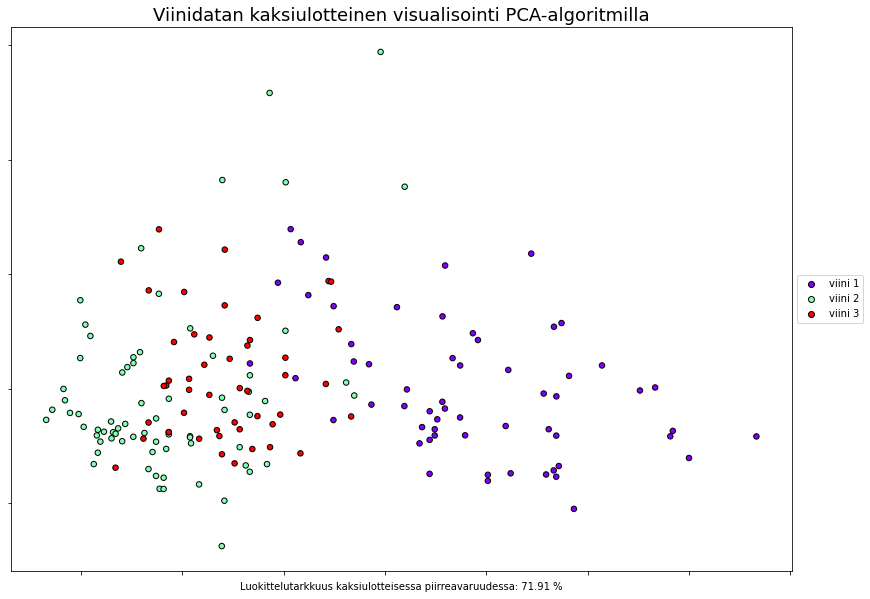

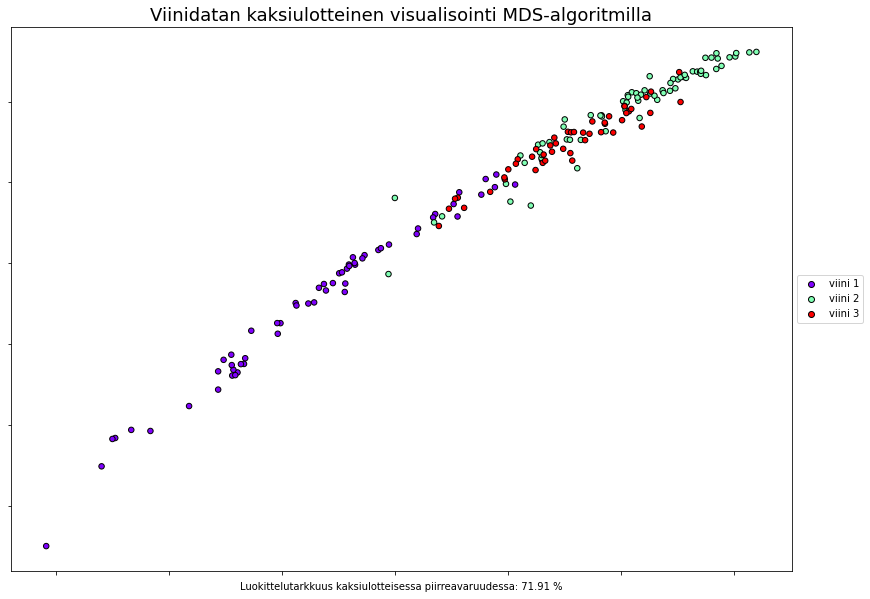

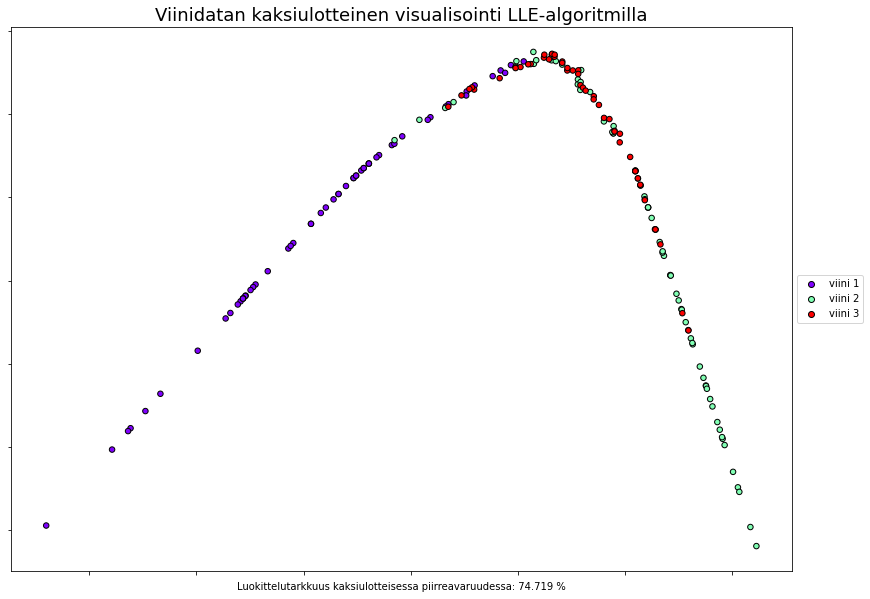

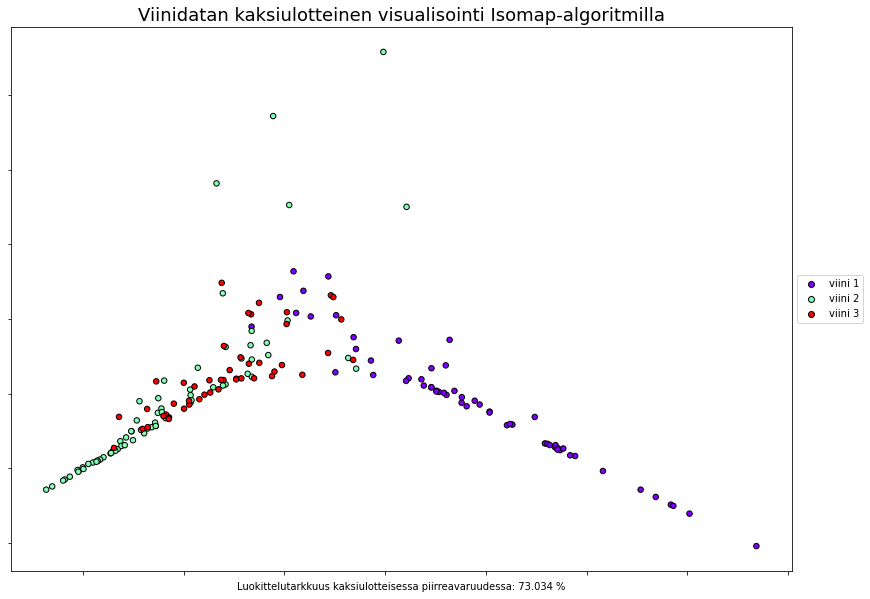

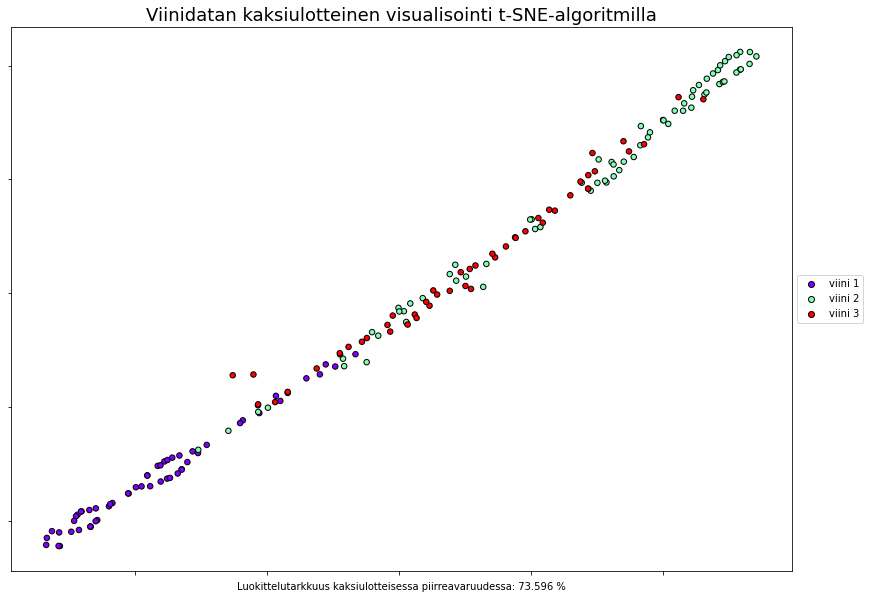

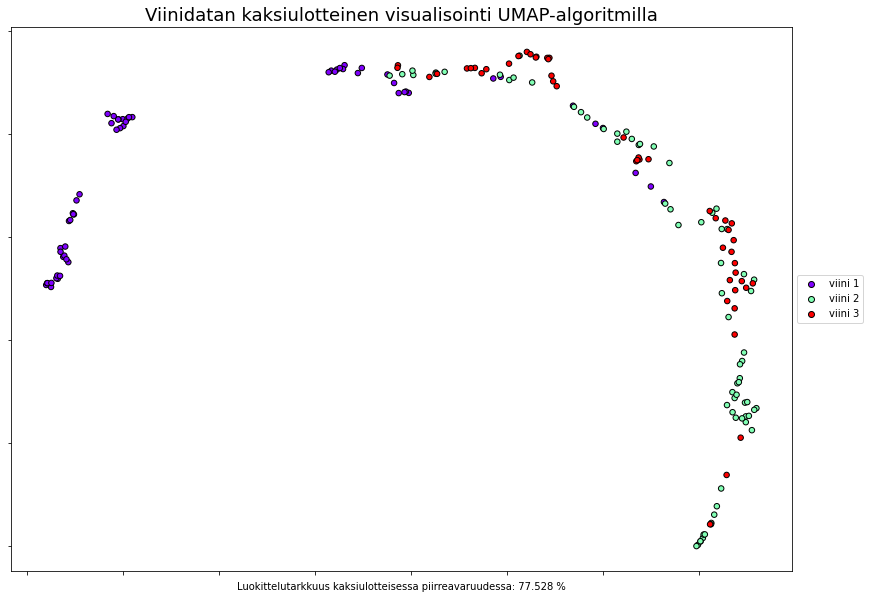

In [12]:
# Suoritetaan dimensionaalisuuden vähentäminen eri menetelmillä viinidatalle
algoritmit = ['PCA','MDS','LLE','Isomap','t-SNE','UMAP']
värit_viini = np.unique(luokat_viini, return_inverse=True)[1]
datat_viini_muunnettu = muunna_data(data_viini, parametrit=[11,13,27,24,0.024])
for i in range(datat_viini_muunnettu.shape[0]):
    fig, ax = plt.subplots(figsize=(14,10))
    plt.scatter(datat_viini_muunnettu[i][:,0],datat_viini_muunnettu[i][:,1], s=30, c=värit_viini,  cmap='rainbow', edgecolor='k')
    selitteet = [plt.plot([],[], marker='o',markeredgecolor='k', color=cm.rainbow(int(j)/(len(luokkien_nimet_viini)-1)), linestyle='None', label=luokkien_nimet_viini[j])[0]  for j in range(len(luokkien_nimet_viini))]
    plt.legend(handles=selitteet, loc='center left', bbox_to_anchor=(1, 0.5))  
    plt.title('Viinidatan kaksiulotteinen visualisointi {}-algoritmilla'.format(algoritmit[i]), fontsize=18)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('Luokittelutarkkuus kaksiulotteisessa piirreavaruudessa: {} %'.format(round(laske_luokittelutarkkuus_muunnetussa_ulottuvuudessa(datat_viini_muunnettu[i], luokat_viini, 15)*100,3)))

**Mitkä kolme dimensionaalisuuden vähentämisemenetelmää visualisoivat parhaiten viinidatan kaksiulotteisten kuvaajien ja luokittelutarkkuuksien perusteella?**

`UMAP, t-SNE ja LLE.`

Suoritetaan seuraavaksi muoti MNIST-datan visualisoiminen eri dimensionaalisuuden vähentämismenetelmillä. 

Aja koodilohkot läpi yksi kerrallaan painamalla 'Run' painiketta nähdäksesi interaktiiviset visualisoinnit. Viemällä kursori datapisteen päälle kuvaajassa, voit tarkastella, millaiset näytteet sijoittavat eri puolille piirreavaruutta. Tarkastelun jälkeen interaktiivisen kuvaajan sulkemisen hoitaa $\text{plt.close('all')}$ komento seuraavassa koodilohkossa.

In [13]:
# Interaktiivisten visualisointien suorittamiseksi tämän koodilohkon ajaminen on välttämätöntä
if INTERACTIVE_MODE:
    %matplotlib notebook
    %matplotlib notebook

In [14]:
def hover(event):
    """
    Tämä funktio mahdollistaa kuvan toistamisen kursorin ollessa datapisteen päällä.
    """
    if data_pisteet.contains(event)[0]:
        indeksit = data_pisteet.contains(event)[1]['ind']
        indeksi = indeksit[0]
        leveys, korkeus = fig.get_size_inches()*fig.dpi
        leveydet = (event.x > leveys/2.)*-1 + (event.x <= leveys/2.) 
        korkeudet = (event.y > korkeus/2.)*-1 + (event.y <= korkeus/2.)
        havainnekuva_boksi.xybox = (kuva_boksin_koko[0]*leveydet, kuva_boksin_koko[1]*korkeudet)
        havainnekuva_boksi.set_visible(True)
        havainnekuva_boksi.xy =(x_koordinaatti[indeksi], y_koordinaatti[indeksi])
        alustettu_kuva.set_data(kuvat_tmp[indeksi,:,:])
    else:
        havainnekuva_boksi.set_visible(False)
    fig.canvas.draw_idle()
    
def interaktiivinen_visualisointi(muunnettu_data, luokat, kuvat, värit, luokkien_nimet, algoritmin_nimi, datan_nimi):
    global data_pisteet, fig, ax, havainnekuva_boksi, kuva_boksin_koko, x_koordinaatti, y_koordinaatti, alustettu_kuva, kuvat_tmp
    # Sijoitetaan datapisteet kuvaajaan
    kuvat_tmp = kuvat
    fig, ax = plt.subplots(figsize=(14,10))
    x_koordinaatti = muunnettu_data[:,0]
    y_koordinaatti = muunnettu_data[:,1]
    data_pisteet = plt.scatter(x_koordinaatti,y_koordinaatti, s=30, c=värit,  cmap='jet', edgecolor='k')
    selitteet = [plt.plot([],[], marker='o',markeredgecolor='k', color=cm.jet(int(i)/(len(luokkien_nimet)-1)), linestyle='None', label=luokkien_nimet[i])[0]  for i in range(len(luokkien_nimet))]
    plt.legend(handles=selitteet, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('{}datan kaksiulotteinen visualisointi {}algoritmilla'.format(datan_nimi, algoritmin_nimi), fontsize=18)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('Luokittelutarkkuus kaksiulotteisessa piirreavaruudessa: {} %'.format(round(laske_luokittelutarkkuus_muunnetussa_ulottuvuudessa(muunnettu_data, luokat, 15)*100,3)))

    # Luodaan havainnekuva    
    alustettu_kuva = OffsetImage(kuvat[1,:,:], zoom=2, cmap=plt.cm.gray_r)
    kuva_boksin_koko = (40, 40)
    havainnekuva_boksi = AnnotationBbox(alustettu_kuva, (0,0), xybox=kuva_boksin_koko, xycoords='data', boxcoords='offset points',  pad=0.3,  arrowprops=dict(arrowstyle='->'))
    ax.add_artist(havainnekuva_boksi)
    havainnekuva_boksi.set_visible(False)
    
    # Suoritetaan kuvan toistaminen hiiren ollessa datapisteen päällä
    fig.canvas.mpl_connect('motion_notify_event', hover)

In [15]:
# Suoritetaan dimensionaalisuuden vähentäminen eri menetelmillä muoti MNIST-datalle
# Huom. jos tämän kohdan ajaminen antaa RuntimeWarning virheilmoituksen, aja se uudestaan
# Ennen kuin ajat seuraavan koodilohkon, odota että tämä välivaihe suoritetaan (kestää hetken aikaa).
datat_muoti_muunnettu = muunna_data(data_muoti, parametrit=[10,10,11,13,0.013])
värit_muoti = np.unique(luokat_muoti, return_inverse=True)[1]
kuvat_muoti = np.reshape(data_muoti, (700,28,28))

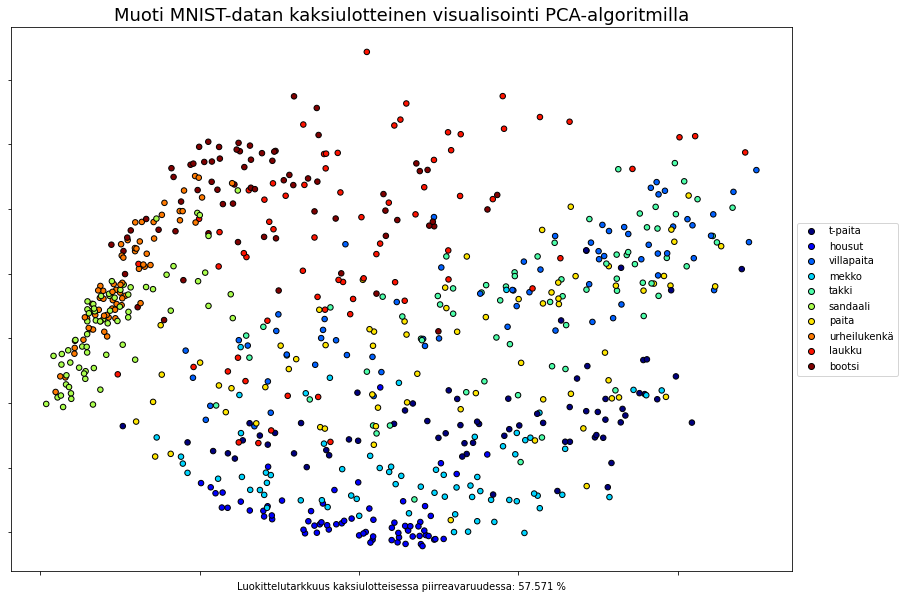

In [16]:
# Muoti MNIST-datan interaktiivinen kaksiulotteinen visualisointi PCA-algoritmilla
interaktiivinen_visualisointi(datat_muoti_muunnettu[0], luokat_muoti, kuvat_muoti, värit_muoti, luokkien_nimet_muoti, 'PCA-', 'Muoti MNIST-')
plt.show();

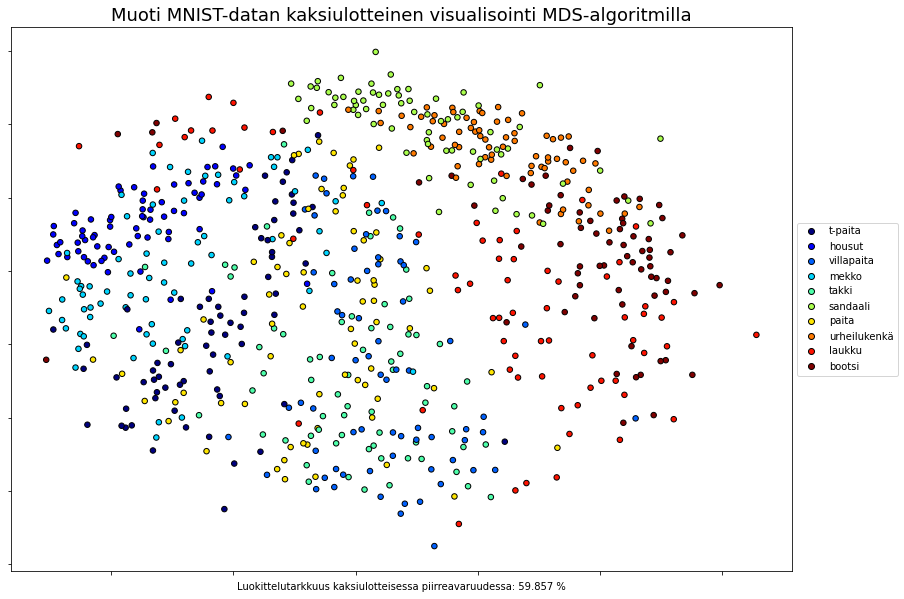

In [17]:
# Suljetaan aiempi interaktiivinen kaksiulotteinen visualisointi
plt.close('all')

# Muoti MNIST-datan kaksiulotteinen interaktiivinen visualisointi MDS-algoritmilla
interaktiivinen_visualisointi(datat_muoti_muunnettu[1], luokat_muoti, kuvat_muoti, värit_muoti, luokkien_nimet_muoti, 'MDS-', 'Muoti MNIST-')
plt.show();

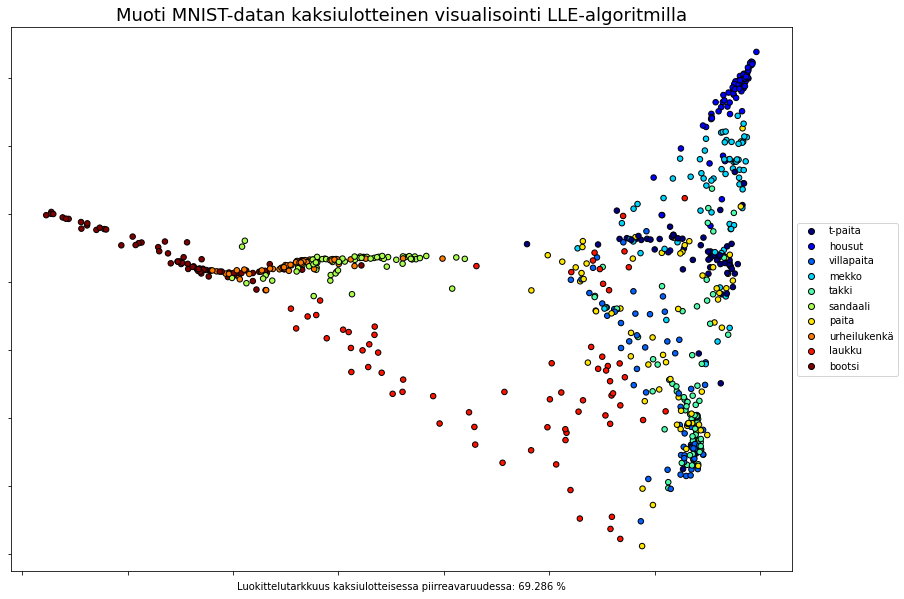

In [18]:
# Suljetaan aiempi interaktiivinen kaksiulotteinen visualisointi
plt.close('all')

# Muoti MNIST-datan kaksiulotteinen interaktiivinen visualisointi LLE-algoritmilla
interaktiivinen_visualisointi(datat_muoti_muunnettu[2], luokat_muoti, kuvat_muoti, värit_muoti, luokkien_nimet_muoti, 'LLE-', 'Muoti MNIST-')
plt.show();

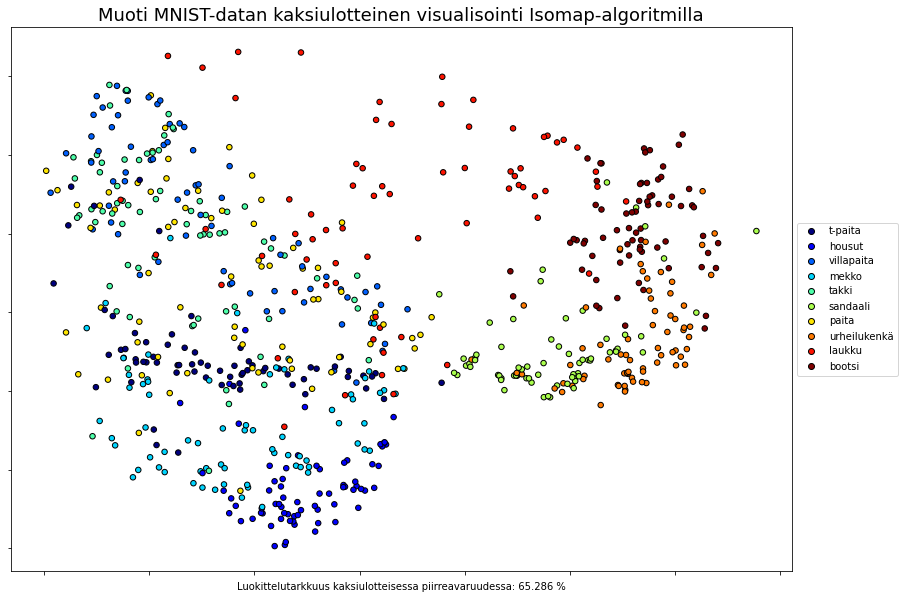

In [19]:
# Suljetaan aiempi interaktiivinen kaksiulotteinen visualisointi
plt.close('all')

# Muoti MNIST-datan kaksiulotteinen interaktiivinen visualisointi Isomap-algoritmilla
interaktiivinen_visualisointi(datat_muoti_muunnettu[3], luokat_muoti, kuvat_muoti, värit_muoti, luokkien_nimet_muoti, 'Isomap-', 'Muoti MNIST-')
plt.show();

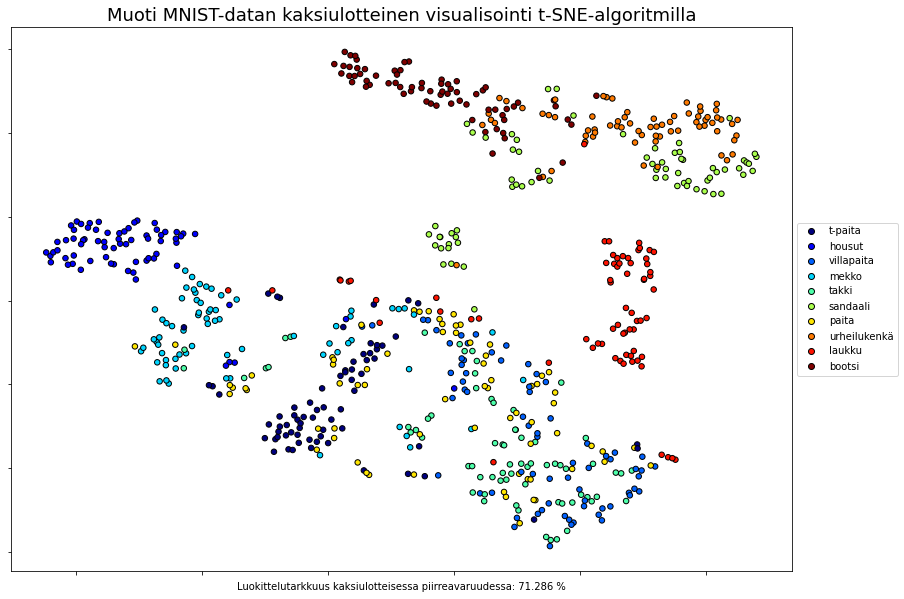

In [20]:
# Suljetaan aiempi interaktiivinen kaksiulotteinen visualisointi
plt.close('all')

# Muoti MNIST-datan kaksiulotteinen interaktiivinen visualisointi t-SNE-algoritmilla
interaktiivinen_visualisointi(datat_muoti_muunnettu[4], luokat_muoti, kuvat_muoti, värit_muoti, luokkien_nimet_muoti, 't-SNE-', 'Muoti MNIST-')
plt.show();

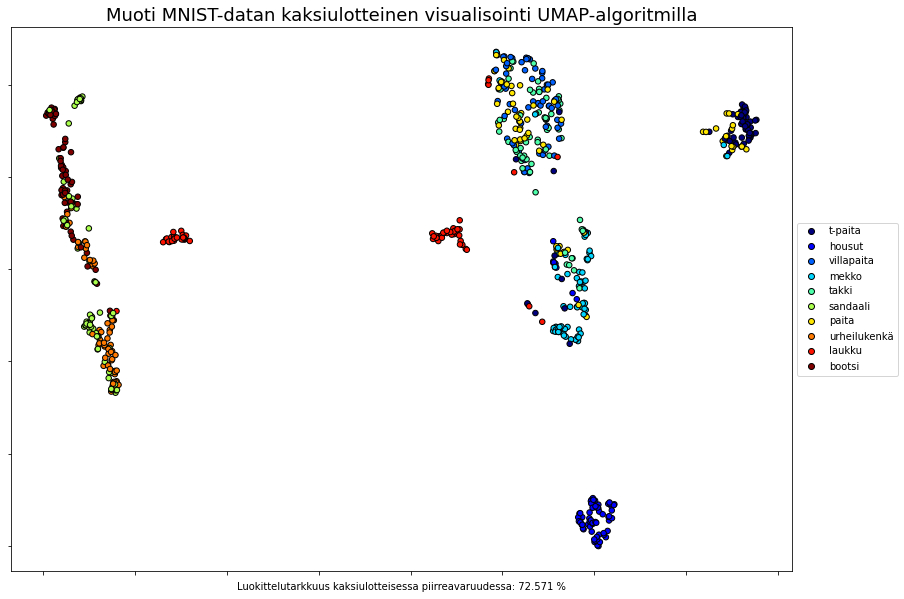

In [21]:
# Suljetaan aiempi interaktiivinen kaksiulotteinen visualisointi
plt.close('all')
# Muoti MNIST-datan interaktiivinen kaksiulotteinen visualisointi UMAP-algoritmilla
interaktiivinen_visualisointi(datat_muoti_muunnettu[5], luokat_muoti, kuvat_muoti, värit_muoti, luokkien_nimet_muoti, 'UMAP-', 'Muoti MNIST-')
plt.show();

In [22]:
# Suljetaan interaktiivinen kaksiulotteinen visualisointi
plt.close('all')

**Mitkä kolme dimensionaalisuuden vähentämisemenetelmää visualisoivat parhaiten muoti MNIST-datan kaksiulotteisten kuvaajien ja luokittelutarkkuuksien perusteella?**

`UMAP, t-SNE, LLE`

### Oksadata

Suoritetaan oksadatan visualisoiminen eri dimensionaalisuuden vähentämismenetelmillä.

In [23]:
# Suoritetaan dimensionaalisuuden vähentäminen kaksiulotteisiksi esityksiksi oksadatalle eri menetelmillä
# Huom. jos tämän kohdan ajaminen antaa RuntimeWarning virheilmoituksen, aja kohta uudestaan
# Ennen kuin ajat seuraavan koodilohkon, odota että tämä välivaihe suoritetaan (kestää hetken aikaa).
datat_oksa_muunnettu = muunna_data(data_oksa, parametrit=[13,26,24,5,0.05])
värit_oksa = np.unique(luokat_oksa, return_inverse=True)[1].tolist()
kuvat_oksa = np.reshape(data_oksa, (438,40,40,3))

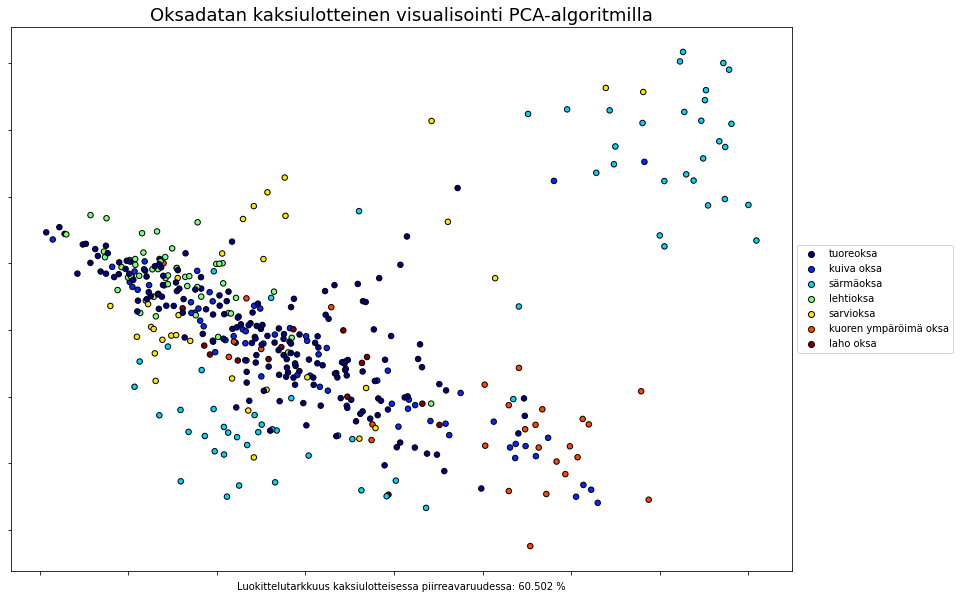

In [24]:
# Suljetaan aiempi interaktiivinen kaksiulotteinen visualisointi
plt.close('all')

# Oksadatan kaksiulotteinen interaktiivinen visualisointi PCA-algoritmilla
interaktiivinen_visualisointi(datat_oksa_muunnettu[0], luokat_oksa, kuvat_oksa, värit_oksa, luokkien_nimet_oksa, 'PCA-', 'Oksa')
plt.show();

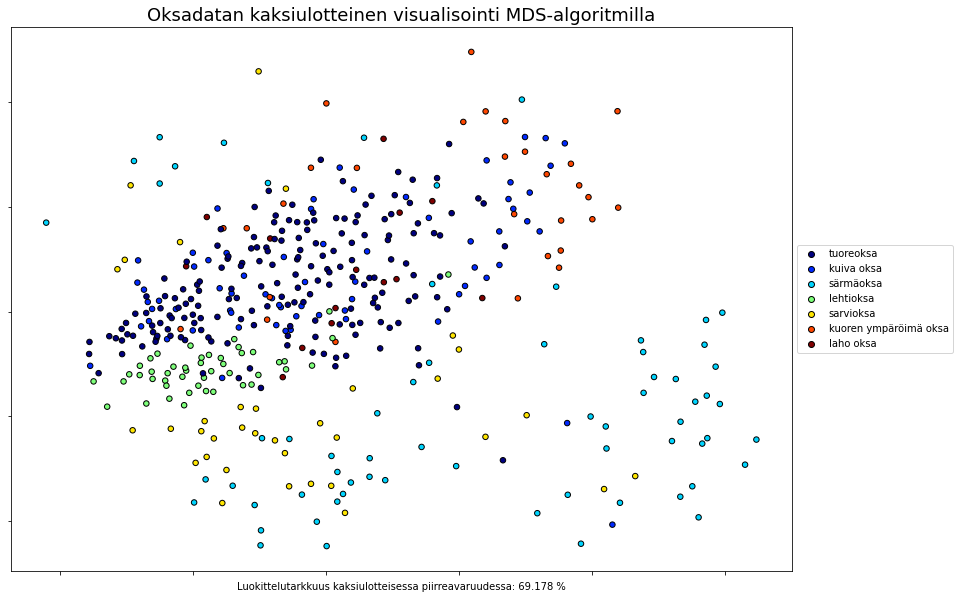

In [25]:
# Suljetaan aiempi interaktiivinen kaksiulotteinen visualisointi
plt.close('all')

# Oksadatan kaksiulotteinen interaktiivinen visualisointi MDS-algoritmilla
interaktiivinen_visualisointi(datat_oksa_muunnettu[1], luokat_oksa, kuvat_oksa, värit_oksa, luokkien_nimet_oksa, 'MDS-', 'Oksa')
plt.show();

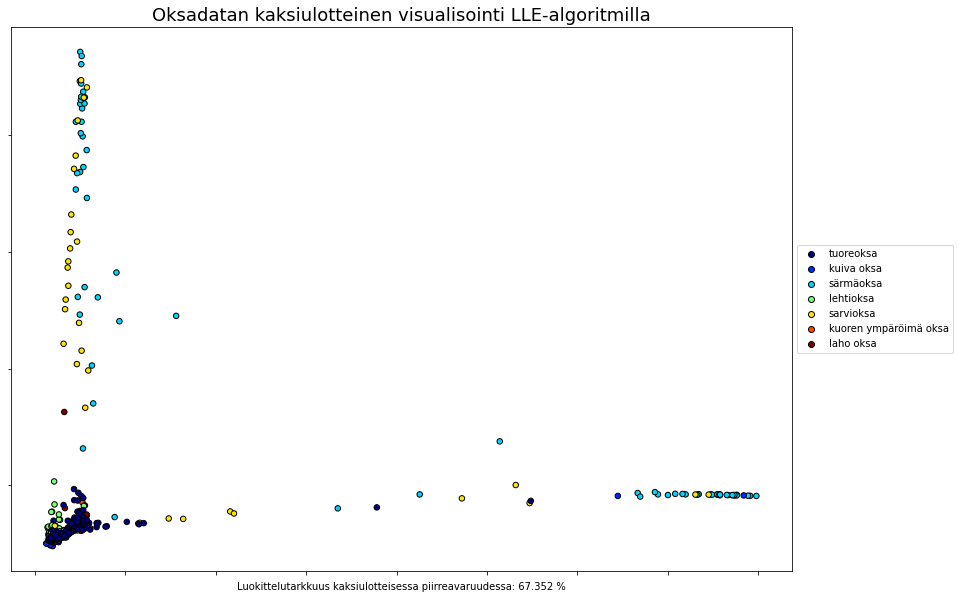

In [26]:
# Suljetaan aiempi interaktiivinen kaksiulotteinen visualisointi
plt.close('all')

# Oksadatan kaksiulotteinen interaktiivinen visualisointi LLE-algoritmilla
interaktiivinen_visualisointi(datat_oksa_muunnettu[2], luokat_oksa, kuvat_oksa, värit_oksa, luokkien_nimet_oksa, 'LLE-', 'Oksa')
plt.show();

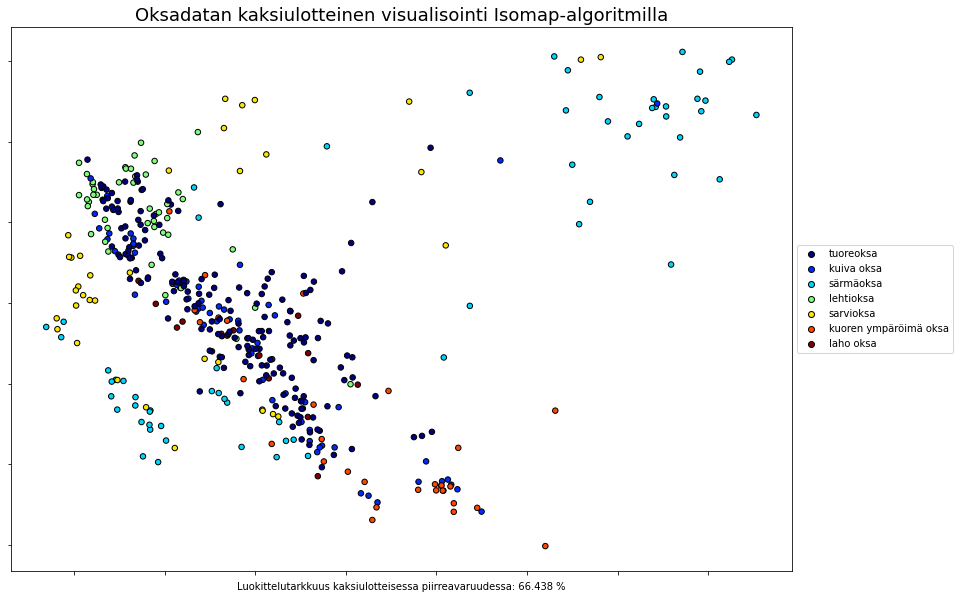

In [27]:
# Suljetaan aiempi interaktiivinen kaksiulotteinen visualisointi
plt.close('all')

# Oksadatan kaksiulotteinen interaktiivinen visualisointi Isomap-algoritmilla
interaktiivinen_visualisointi(datat_oksa_muunnettu[3], luokat_oksa, kuvat_oksa, värit_oksa, luokkien_nimet_oksa, 'Isomap-', 'Oksa')
plt.show();

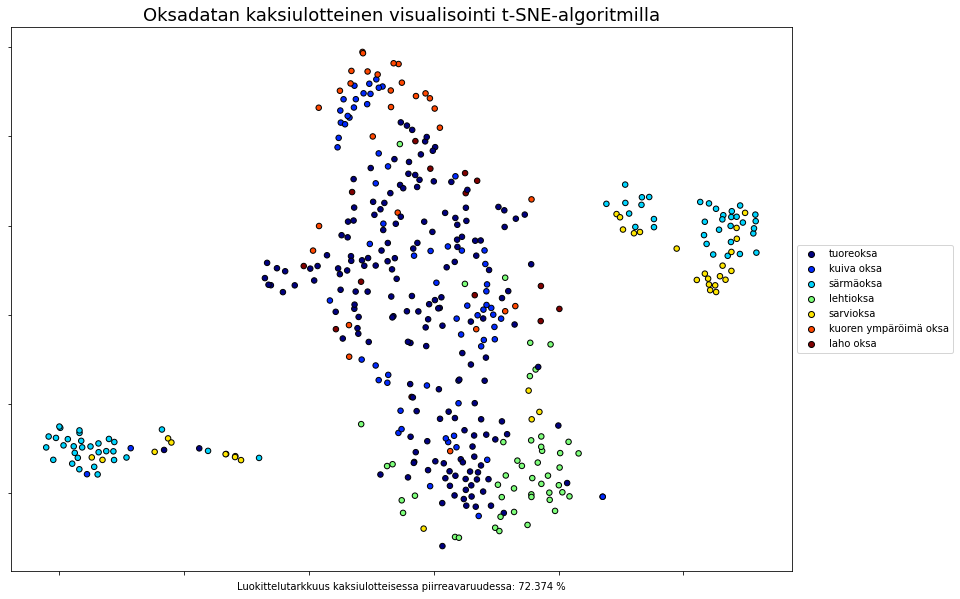

In [28]:
# Suljetaan aiempi interaktiivinen kaksiulotteinen visualisointi
plt.close('all')

# Oksadatan kaksiulotteinen interaktiivinen visualisointi t-SNE-algoritmilla
interaktiivinen_visualisointi(datat_oksa_muunnettu[4], luokat_oksa, kuvat_oksa, värit_oksa, luokkien_nimet_oksa, 't-SNE-', 'Oksa')
plt.show();

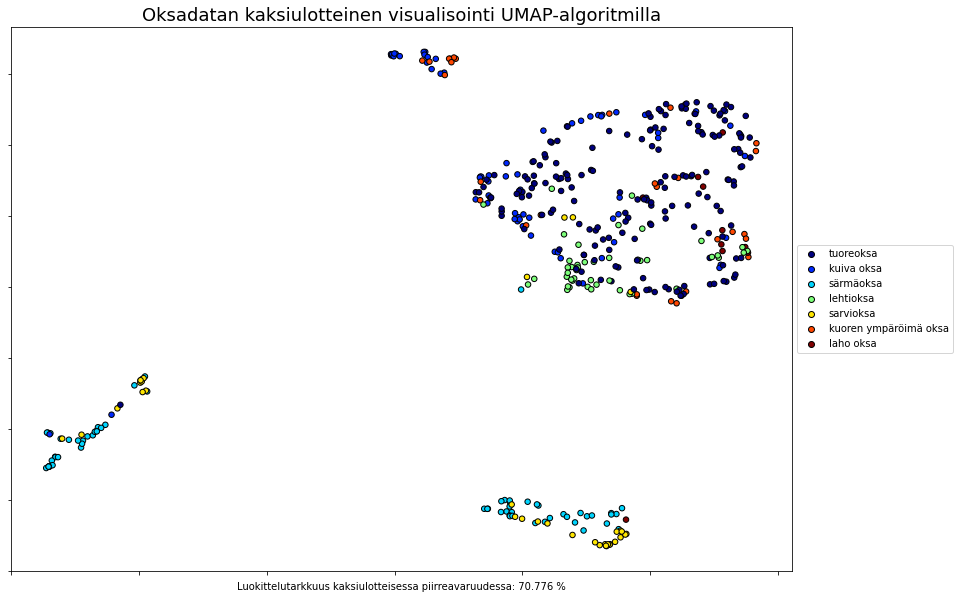

In [29]:
# Suljetaan aiempi interaktiivinen kaksiulotteinen visualisointi
plt.close('all')

# Oksadatan kaksiulotteinen interaktiivinen visualisointi UMAP-algoritmilla
interaktiivinen_visualisointi(datat_oksa_muunnettu[5], luokat_oksa, kuvat_oksa, värit_oksa, luokkien_nimet_oksa, 'UMAP-', 'Oksa')
plt.show();

In [30]:
# Suljetaan aiempi interaktiivinen kaksiulotteinen visualisointi
plt.close('all')

**Mitkä kolme dimensionaalisuuden vähentämisemenetelmää visualisoivat parhaiten oksadatan kaksiulotteisten kuvaajien ja luokittelutarkkuuksien perusteella?**

`MDS, t-SNE, UMAP`

**Miksi pääkomponenttianalyysi ei onnistu kovin hyvin visualisoinneissa muoti MNIST-datalle ja oksadatalle?**

`Pääkomponenttianalyysi on lineaarinen menetelmä, eikä ole kovin hyvä datalle, jossa on epälineaarisia riippuvuuksia.`

## Piirteiden lukumäärän vähentäminen

Toinen yleinen käyttötarkoitus dimensionaalisuuden vähentämiselle on piirteiden tehokas pakkaaminen luokittelijan opettamiseen kuluvan laskenta-ajan pienentämiseksi. Käytetään pääkomponenttianalyysia irrottamaan muoti MNIST-datan alkuperäisten muuttujien informaatio pääkomponentteihin. Tämän jälkeen käydään läpi piirteiden lukumäärät 1-700 kymmenen askeleen välein. 

Laske luokittelutarkkuus k-lähimmän naapurin luokittelijalle ja luokittelijan opettamiseen kuluva aika, kun $k$ on 5. Lisää luokittelutarkkuudet ja laskenta-ajat listoihin. Piirretään lopuksi kuvaajaan, miten luokittelutarkkuudet ja luokittelijan opettamiseen kuluva laskenta-aika riippuvat piirteiden lukumäärästä. 

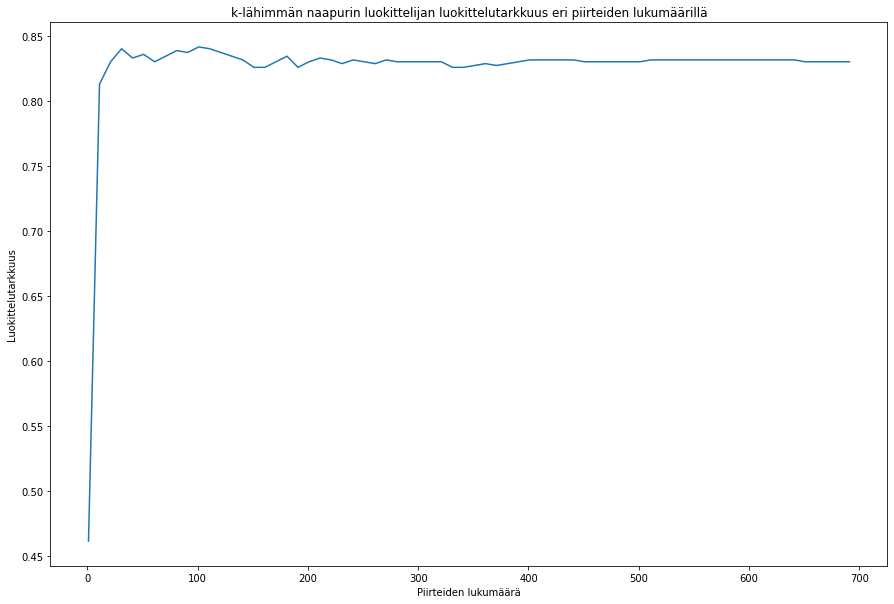

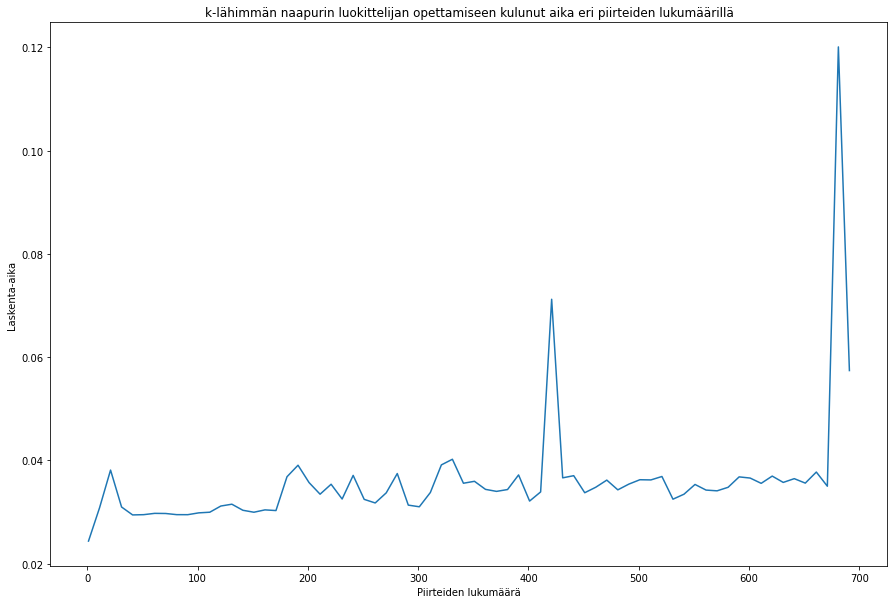

Optimaalisella määrällä piirteitä (101) luokittelutarkkuus on 84.143 % ja luokittelijan opettamiseen kulunut aika on 0.03 sekuntia.


In [31]:
%matplotlib inline
luokittelutarkkuudet = []
laskenta_ajat = []
    
# Suoritetaan pääkomponenttianalyysi muoti MNIST-datalle
data_muoti_pca = PCA(n_components=700, random_state=0).fit_transform(data_muoti)

# Käydään läpi piirteiden lukumäärät 1-700 kymmenen askeleen välein, opetetaan k-lähimmän naapurin luokittelija ja lasketaan luokittelutarkkuus ja opettamiseen kulunut aika
piirteiden_lukumäärät = range(1,700,10)
for i in piirteiden_lukumäärät:
    # Valitaan muunnetusta datasta i ensimmäistä pääkomponenttia
    data_muoti_muunnettu = data_muoti_pca[:,0:i]
    #-------TÄHÄN SINUN KOODI--------
    # Ota alkuajanhetki t1 ylös (Vihje: time.time())
    t1 = time.time()
    # Laske luokittelutarkkuus luokittelijalle funktiolla laske_luokittelutarkkuus_muunnetussa_ulottuvuudessa(data_muoti_muunnettu, luokat_muoti, 5), kun k on 5.
    luokittelutarkkuus = laske_luokittelutarkkuus_muunnetussa_ulottuvuudessa(data_muoti_muunnettu, luokat_muoti, 5)
    # Ota luokittelijan opettamisen jälkeen ajanhetki t2 (Vihje: time.time())
    t2 = time.time()
    # Laske ajanhetkien erotus saadaksesi selville opettamiseen kuluneen ajan
    kulunut_aika = t2 - t1
    # Lisää laskettu luokittelutarkkuus listaan luokittelutarkkuudet
    luokittelutarkkuudet.append(luokittelutarkkuus)
    # Lisää ajanhetkien erotus listaan laskenta_ajat
    laskenta_ajat.append(kulunut_aika)
    #--------------------------------
    
# Piirretään kuvaajaan piirteiden lukumäärän vaikutus luokittelijan luokittelutarkkuuteen
plt.figure(figsize=(15,10))
plt.plot(piirteiden_lukumäärät, luokittelutarkkuudet)
plt.title('k-lähimmän naapurin luokittelijan luokittelutarkkuus eri piirteiden lukumäärillä')
plt.xlabel('Piirteiden lukumäärä')
plt.ylabel('Luokittelutarkkuus')

# Piirretään kuvaajaan piirteiden lukumäärän vaikutus luokittelijan opettamiseen kuluneeseen aikaan
plt.figure(figsize=(15,10))
plt.plot(piirteiden_lukumäärät, laskenta_ajat)
plt.title('k-lähimmän naapurin luokittelijan opettamiseen kulunut aika eri piirteiden lukumäärillä')
plt.xlabel('Piirteiden lukumäärä')
plt.ylabel('Laskenta-aika')
plt.show()

# Valitaan lopuksi luokittelutarkkuuksien kuvaajasta optimaalinen määrä piirteitä
maksimi_indeksi_knn = np.argmax(luokittelutarkkuudet)
print('Optimaalisella määrällä piirteitä ({}) luokittelutarkkuus on {} % ja luokittelijan opettamiseen kulunut aika on {} sekuntia.'.format(piirteiden_lukumäärät[maksimi_indeksi_knn], round(luokittelutarkkuudet[maksimi_indeksi_knn]*100,3), round(laskenta_ajat[maksimi_indeksi_knn],3)))

**Mistä ilmiöstä on kyse, kun k-lähimmän naapurin luokittelijan suorituskyky on alkuperäisen datan muuttujia reilusti pienemmällä määrällä piirteitä parempi? Miten luokittelijan opettamiseen kulunut aika riippuu piirteiden lukumäärästä?**

`Liian suurella määrällä piirteitä voi tapahtua ylioppimista, jolloin malli ei enää kuvaakaan datasettiä tarpeeksi kattavasti, kun sitä käytetään luokitteluun. Opettamiseen kuluneessa ajassa on aika paljon vaihtelua mutta aika näyttäisi kasvavan suuremmilla määrillä piirteitä.`